# Predicting Movie Genre using the Cast
Various aspects of a film, such as its poster or its description, have been used to develop models that can predict the genre of a given movie. Many actors are associated with particular genres of film. Bruce Willis, for example, most often appears in action movies. Thus, I set out to see if a model could use a movie's cast to accurately predict its genre(s). Furthermore, I experimented with how many members of a cast are taken into consideration by the model.

This objective comes with some setbacks though. Actors can be said to have varying degrees of "range", or ability to act well in diverse rolls. So, if a movie features several actors with high levels of range, it may be challening for the model to correctly forcast the genre(s) of that movie. To identify how an actor's range influences the model's predictive ability, I quantified the range of each actor and experimented with excluding actors of a certain range score from the model's data sets.

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split
from scipy import spatial

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings("ignore")

2022-12-03 23:43:55.434397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 23:43:55.579467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 23:43:55.579506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 23:43:55.604851: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-03 23:43:56.345607: W tensorflow/stream_executor/platform/de

In [2]:
# data source: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
df1 = pd.read_csv('imdb_top_1000.csv')

# data source: https://www.kaggle.com/datasets/PromptCloudHQ/imdb-data
df2 = pd.read_csv('IMDB-Movie-Data.csv')

df = pd.DataFrame(columns = ['Title', 'Release Year', 'Rating', 'Genre', 'Director', 'Cast', 'Duration'])

### Data Representation and Cleaning
I compiled the data from two sources above into one dataframe, disregarding any columns that they did not have in common. Actors and movies from around the world were included in this data. Initially, I stored the genres and cast of each movie as a list of strings. One entry erroneously had "PG" as its release year, so I corrected that. There were no null entries in the dataframe, so no N/A values needed to be filled.

To make the genre and cast data more usable, I performed one hot encoding on the genres, producing a column for every genre. I performed a similar one hot encoding using the cast, but kept the cast as a single column in the dataframe. Instead, I replaced the cast string array with a binary array where each actor was an index in the array. A 1 indicated the actor was a member of the cast of that film and 0 indicated they were not. Before creating my model, I dropped all columns but the genre and cast as these were irrelevant to the model's predictions.

In [3]:
for index, movie in df1.iterrows():
    if movie['Series_Title'] not in df.values:
        castlist = []
        castlist.append(movie['Star1'])
        castlist.append(movie['Star2'])
        castlist.append(movie['Star3'])
        castlist.append(movie['Star4'])
        
        genrelist = (movie['Genre']).split(", ")
        
        df = df.append({'Title' : movie['Series_Title'], 'Release Year' : movie['Released_Year'], 
                        'Rating' : movie['IMDB_Rating'], 'Genre' : genrelist, 'Director' : movie['Director'],
                        'Cast' : castlist, 'Duration' : movie['Runtime'][:(len(movie['Runtime'])) - 4]}, ignore_index = True)
        
for index, movie in df2.iterrows():
    if movie['Title'] not in df.values:
        castlist = []
        castlist = (movie['Actors']).split(',')
        
        genrelist = (movie['Genre']).split(",")
        
        df = df.append({'Title' : movie['Title'], 'Release Year' : movie['Year'], 
                        'Rating' : movie['Rating'], 'Genre' : genrelist, 'Director' : movie['Director'],
                        'Cast' : castlist, 'Duration' : movie['Runtime (Minutes)']}, ignore_index = True)

In [4]:
print(df.loc[df['Release Year']=='PG'])
df=df.replace('PG', 1995)
print(df.loc[df['Release Year']==1995])

         Title Release Year  Rating                        Genre    Director  \
965  Apollo 13           PG     7.6  [Adventure, Drama, History]  Ron Howard   

                                                  Cast Duration  
965  [Tom Hanks, Bill Paxton, Kevin Bacon, Gary Sin...      140  
         Title Release Year  Rating                        Genre    Director  \
965  Apollo 13         1995     7.6  [Adventure, Drama, History]  Ron Howard   

                                                  Cast Duration  
965  [Tom Hanks, Bill Paxton, Kevin Bacon, Gary Sin...      140  


In [5]:
df.head()

,Title,Release Year,Rating,Genre,Director,Cast,Duration
0,The Shawshank Redemption,1994,9.3,[Drama],Frank Darabont,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",142
1,The Godfather,1972,9.2,"[Crime, Drama]",Francis Ford Coppola,"[Marlon Brando, Al Pacino, James Caan, Diane K...",175
2,The Dark Knight,2008,9.0,"[Action, Crime, Drama]",Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",152
3,The Godfather: Part II,1974,9.0,"[Crime, Drama]",Francis Ford Coppola,"[Al Pacino, Robert De Niro, Robert Duvall, Dia...",202
4,12 Angry Men,1957,9.0,"[Crime, Drama]",Sidney Lumet,"[Henry Fonda, Lee J. Cobb, Martin Balsam, John...",96


In [6]:
df.shape

(1820, 7)

In [7]:
df.isna().sum()

Title           0
Release Year    0
Rating          0
Genre           0
Director        0
Cast            0
Duration        0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1820 non-null   object 
 1   Release Year  1820 non-null   object 
 2   Rating        1820 non-null   float64
 3   Genre         1820 non-null   object 
 4   Director      1820 non-null   object 
 5   Cast          1820 non-null   object 
 6   Duration      1820 non-null   object 
dtypes: float64(1), object(6)
memory usage: 99.7+ KB


In [9]:
df['Release Year']=df['Release Year'].astype('int64')
df['Duration']=df['Duration'].astype('int64')

In [10]:
df.describe()

,Release Year,Rating,Duration
count,1820.000000,1820.000000,1820.000000
mean,2001.066484,7.281648,117.287363
std,20.503703,0.945551,24.504599
min,1920.000000,1.900000,45.000000
25%,1996.000000,6.700000,100.000000
50%,2010.000000,7.600000,113.000000
75%,2015.000000,8.000000,129.000000
max,2020.000000,9.300000,321.000000


In [11]:
df.describe(include=["O"])

,Title,Genre,Director,Cast
count,1820,1820,1820,1820
unique,1820,270,989,1815
top,The Shawshank Redemption,[Drama],Steven Spielberg,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi..."
freq,1,124,16,2


In [12]:
genres = []

for item in df['Genre']:
    for g in item:
        if g not in genres:
            genres.append(g)
            
print(genres)

['Drama', 'Crime', 'Action', 'Adventure', 'Biography', 'History', 'Sci-Fi', 'Romance', 'Western', 'Fantasy', 'Comedy', 'Thriller', 'Animation', 'Family', 'War', 'Mystery', 'Music', 'Horror', 'Musical', 'Film-Noir', 'Sport']


In [13]:
for genre in df['Genre']:
    df[genre] = 0
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1820 non-null   object 
 1   Release Year  1820 non-null   int64  
 2   Rating        1820 non-null   float64
 3   Genre         1820 non-null   object 
 4   Director      1820 non-null   object 
 5   Cast          1820 non-null   object 
 6   Duration      1820 non-null   int64  
 7   Drama         1820 non-null   int64  
 8   Crime         1820 non-null   int64  
 9   Action        1820 non-null   int64  
 10  Adventure     1820 non-null   int64  
 11  Biography     1820 non-null   int64  
 12  History       1820 non-null   int64  
 13  Sci-Fi        1820 non-null   int64  
 14  Romance       1820 non-null   int64  
 15  Western       1820 non-null   int64  
 16  Fantasy       1820 non-null   int64  
 17  Comedy        1820 non-null   int64  
 18  Thriller      1820 non-null 

In [14]:
df_copy = df.drop('Genre', axis=1)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1820 non-null   object 
 1   Release Year  1820 non-null   int64  
 2   Rating        1820 non-null   float64
 3   Director      1820 non-null   object 
 4   Cast          1820 non-null   object 
 5   Duration      1820 non-null   int64  
 6   Drama         1820 non-null   int64  
 7   Crime         1820 non-null   int64  
 8   Action        1820 non-null   int64  
 9   Adventure     1820 non-null   int64  
 10  Biography     1820 non-null   int64  
 11  History       1820 non-null   int64  
 12  Sci-Fi        1820 non-null   int64  
 13  Romance       1820 non-null   int64  
 14  Western       1820 non-null   int64  
 15  Fantasy       1820 non-null   int64  
 16  Comedy        1820 non-null   int64  
 17  Thriller      1820 non-null   int64  
 18  Animation     1820 non-null 

In [15]:
for index, movie in df.iterrows():
    for gen in movie['Genre']:
        df_copy.loc[index, gen] = 1 

In [16]:
df_copy.head()

,Title,Release Year,Rating,Director,Cast,Duration,Drama,Crime,Action,Adventure,...,Thriller,Animation,Family,War,Mystery,Music,Horror,Musical,Film-Noir,Sport
0,The Shawshank Redemption,1994,9.3,Frank Darabont,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",142,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,1972,9.2,Francis Ford Coppola,"[Marlon Brando, Al Pacino, James Caan, Diane K...",175,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Dark Knight,2008,9.0,Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",152,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,The Godfather: Part II,1974,9.0,Francis Ford Coppola,"[Al Pacino, Robert De Niro, Robert Duvall, Dia...",202,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12 Angry Men,1957,9.0,Sidney Lumet,"[Henry Fonda, Lee J. Cobb, Martin Balsam, John...",96,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Visualization
The most frequent movie genre by far was Drama, while the rest of the genres had far more balanced frequencies when compared to each other. This likely reflects the natural categorization of movies, so no changed need to be made to balance the genre distribution. All actors had fairly equal representation in the datasets. It does not seem like much needs to be done to balance the data.

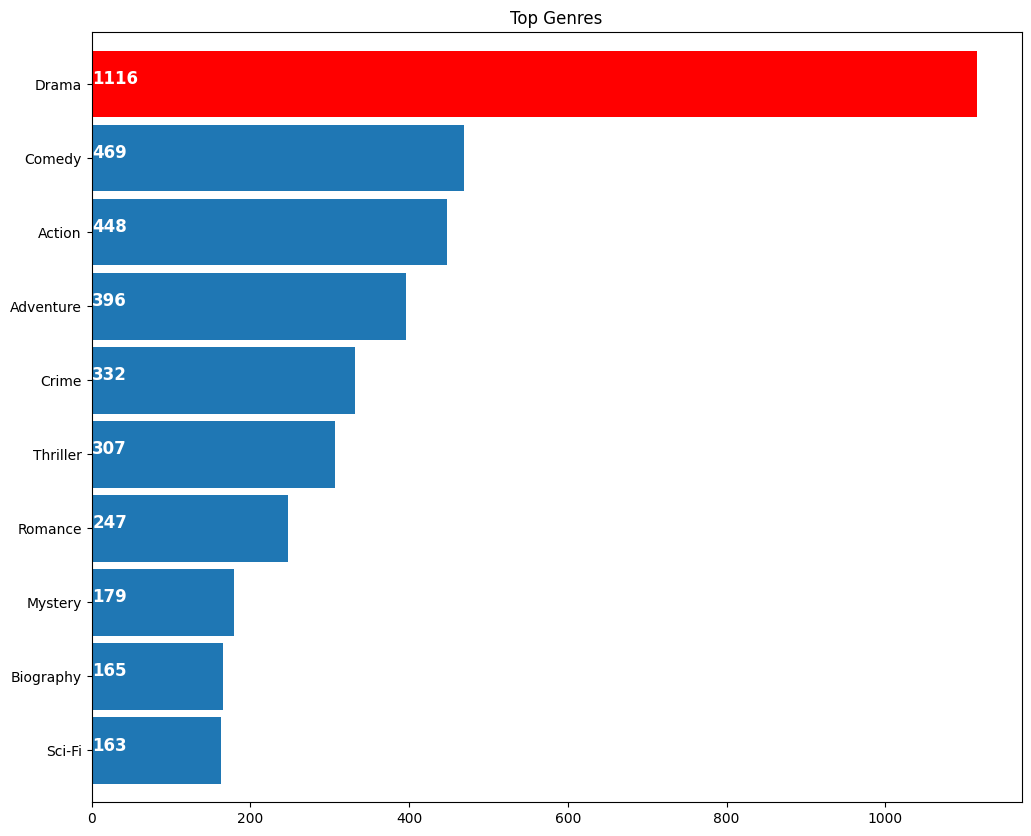

In [17]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df['Genre']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('r')
plt.title('Top Genres')
plt.show()

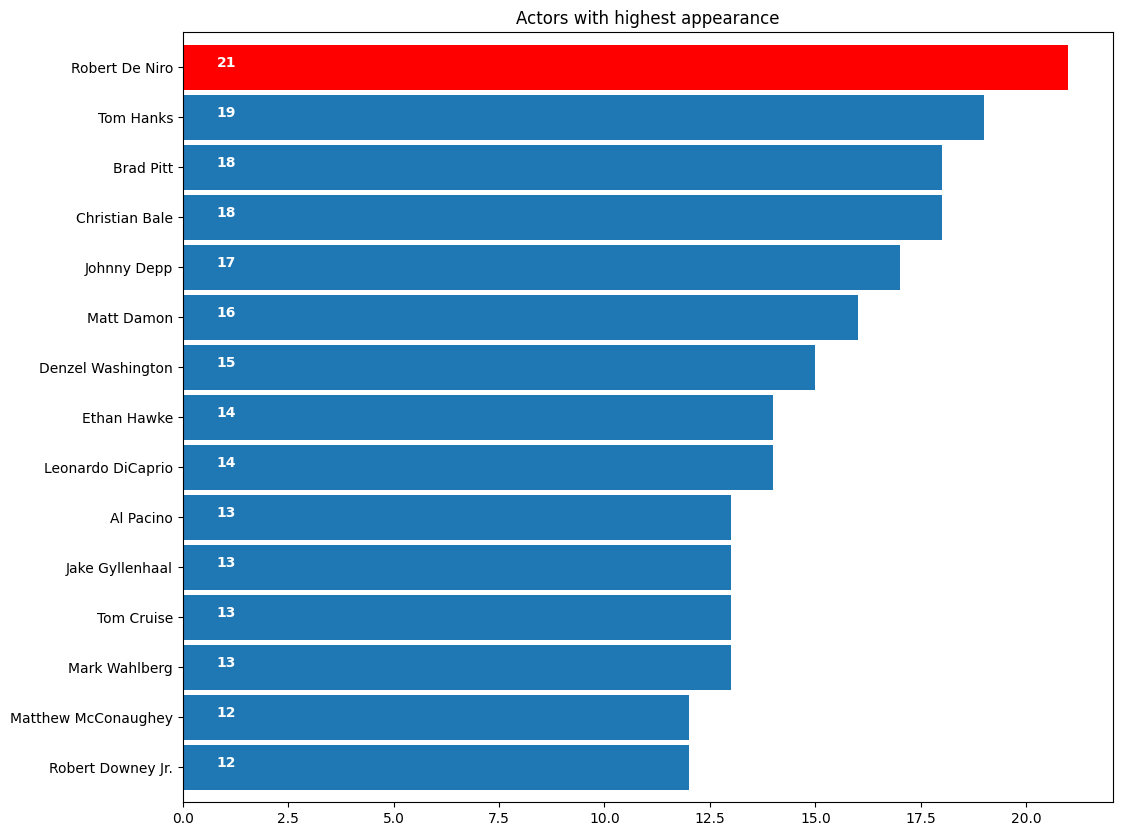

In [18]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df['Cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()

### Data Reorganization
I created a dictionary to store each actor and the movies they were in to make finding movies by actor easier later on.

In [19]:
movies_by_actor = {}

for index, movie in df.iterrows():
    for actor in movie['Cast']:
        if actor not in movies_by_actor.keys():
            movies_by_actor[actor] = []
        movies_by_actor[actor].append(movie['Title'])

In [20]:
genres_apt = {g:0 for i, g in enumerate(genres)}
print(genres_apt)

{'Drama': 0, 'Crime': 0, 'Action': 0, 'Adventure': 0, 'Biography': 0, 'History': 0, 'Sci-Fi': 0, 'Romance': 0, 'Western': 0, 'Fantasy': 0, 'Comedy': 0, 'Thriller': 0, 'Animation': 0, 'Family': 0, 'War': 0, 'Mystery': 0, 'Music': 0, 'Horror': 0, 'Musical': 0, 'Film-Noir': 0, 'Sport': 0}


### Range
I created a formula to quantify an actor's range, as it is usually a fairly subjective measure. I created two dictionaries for each actor. genres_count kept count of each actor's total appearances in movies of each genre. genres_apt kept track of the sum total of the ratings of the movies they appeared in by genre. I decided to take rating into account because an actor's range depends on the quality of their performance in their role. However, no data is available to quantify that metric. Instead, I assumed that the quality of the actor's performance was similar to the overall movie's quality, as poor acting normally indicates a poorly made movie. Of course, this is an imperfect measure of acting quality. After filling these dictionaries appropriately, I summed the total number of genres the actor appeared in, ges, and summed the averages of their performances for each genre, rng. I then multiplied these sums in order to counteract an issue that was arising with actors who were only cast in one movie in the dataset. These actors, as they only appeared in one movie, were assigned a very low range despite possibly having greater range than the limited data on them would indicate. I then divided this number by the total number of genres, 21, to reach each actor's range. After assessing the range of various actors I was familiar with in the list, this seemed to be a reasonably accurate assessment of range given the data I obtained.

The distribution of range values was heavily biased toward the lower end of the range, with actors who tended to appear in more movies typically having a higher range. I was not able to fully counteract the effect of number of movie appearances in the range calculation. However, this distribution may partly result from the tendency of Hollywood to cast familiar actors in many movies, indicating that these actors may display a greater degree of range than less popular actors. Nonetheless, there is almost certainly some bias in the range scores that arises from underrepresentation of some actors compared to others.

In [21]:
actor_range = {}

for actor in movies_by_actor:
    rng = 0
    total = 0
    ges = 0
    
    genres_count = {g:0 for i, g in enumerate(genres)}
    genres_apt = {g:0 for i, g in enumerate(genres)}

    for movie in movies_by_actor[actor]:
        for ge in df.loc[df['Title'] == movie]['Genre']:
            for genre in ge:
                genres_count[genre] += 1
                total += 1
                genres_apt[genre] += df.loc[df['Title'] == movie, 'Rating'].iloc[0]

    for item in genres_apt:
        if genres_count[item] != 0:
            ges += 1
            rng += genres_apt[item] / genres_count[item]
    actor_range[actor] = rng * ges /21 

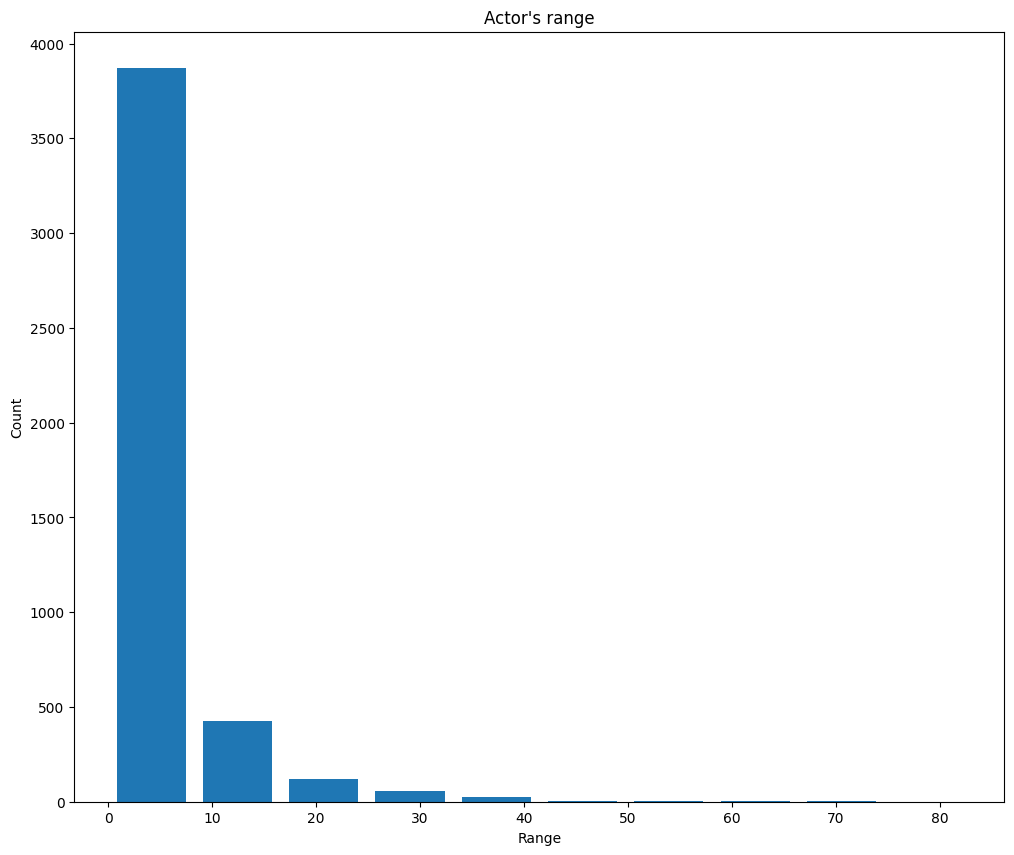

In [22]:
vals = actor_range.values()

plt.subplots(figsize=(12,10))
plt.hist(vals, 10, (0,83), histtype = 'bar', rwidth = 0.8)

plt.xlabel('Range')
plt.ylabel('Count')
plt.title("Actor's range")

plt.show()

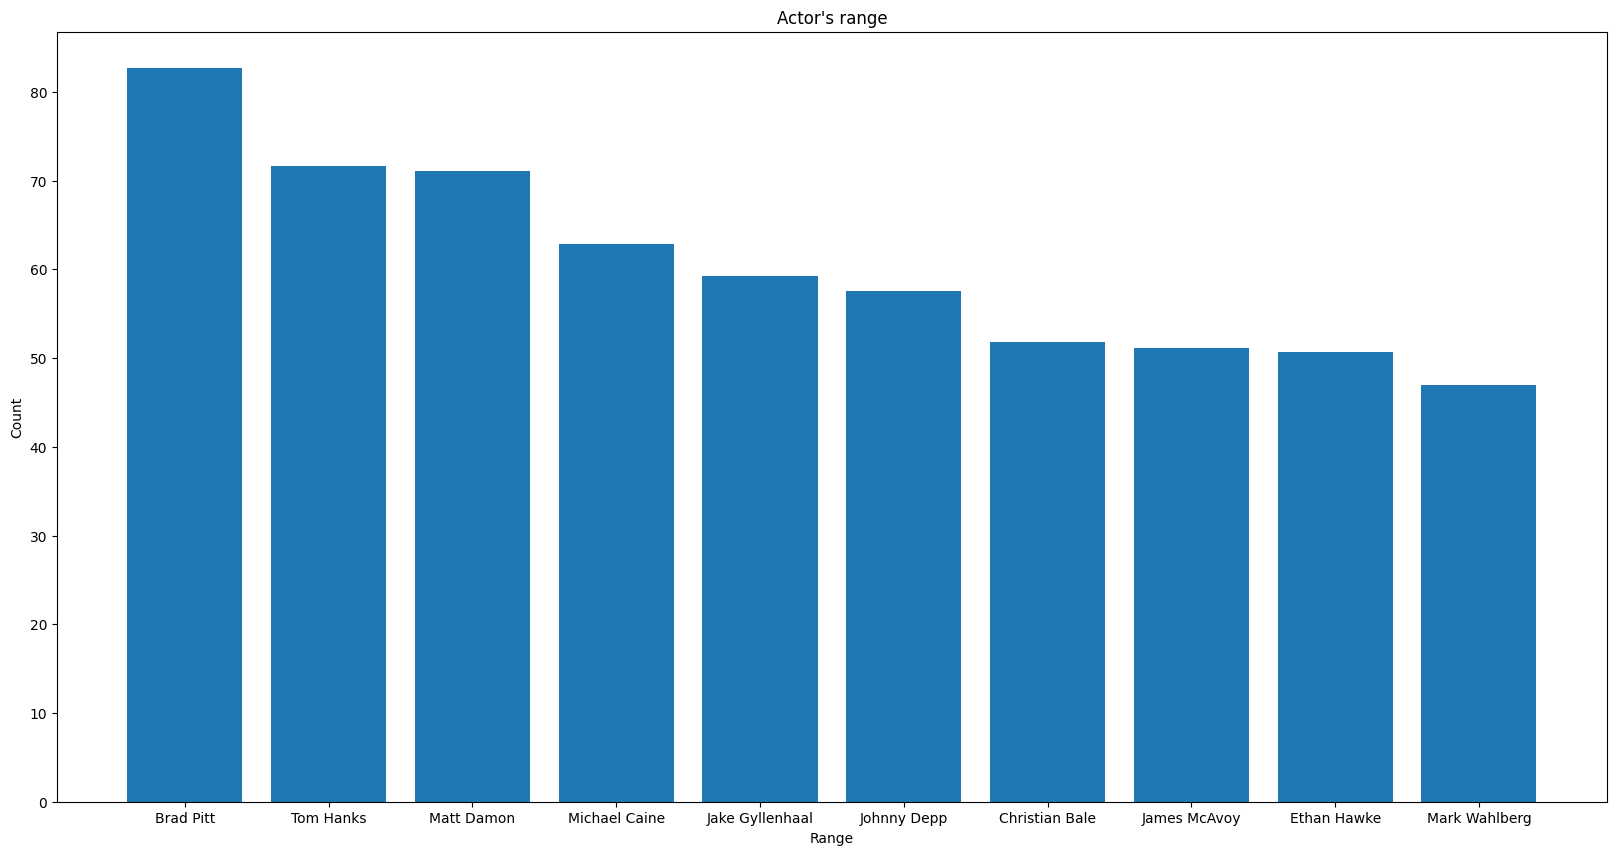

In [23]:
range_copy = actor_range.copy()
top = []
top_range = []
for i in range (0,10):
    temp = list(range_copy.keys())[list(range_copy.values()).index(max(range_copy.values()))]
    top.append(temp)
    top_range.append(range_copy[temp])
    range_copy.pop(top[i])

plt.subplots(figsize=(20,10))

plt.bar(top, top_range, width = 0.8)

plt.xlabel('Range')
plt.ylabel('Count')
plt.title("Actor's range")

plt.show()

In [24]:
def to_bin(lis, features):
    newLis = []
    for feature in features:
        if feature in lis:
            newLis.append(1)
        else:
            newLis.append(0)
    return newLis

In [25]:
df_copy['Cast'] = df_copy['Cast'].apply(lambda x: to_bin(x, movies_by_actor.keys()))

In [26]:
df_copy.head()

,Title,Release Year,Rating,Director,Cast,Duration,Drama,Crime,Action,Adventure,...,Thriller,Animation,Family,War,Mystery,Music,Horror,Musical,Film-Noir,Sport
0,The Shawshank Redemption,1994,9.3,Frank Darabont,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",142,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,1972,9.2,Francis Ford Coppola,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",175,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Dark Knight,2008,9.0,Christopher Nolan,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...",152,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,The Godfather: Part II,1974,9.0,Francis Ford Coppola,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",202,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12 Angry Men,1957,9.0,Sidney Lumet,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",96,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_stripped = df_copy.drop(['Title', 'Release Year', 'Rating', 'Director', 'Duration'], axis=1)
df_stripped.head()

,Cast,Drama,Crime,Action,Adventure,Biography,History,Sci-Fi,Romance,Western,...,Thriller,Animation,Family,War,Mystery,Music,Horror,Musical,Film-Noir,Sport
0,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...",1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### The Model
I split the data into training, validation, and test sets.

After experimenting with adding and removing dense layers, changing these layers' shapes, and adding in dropout layers, I found that the configuration below performed best. Adding dropout layers did little to accelerate the loss convergence and slightly decreased the accuracy of the model, so I omitted them. The batch size and number of epochs were also determined by trial and error.

I also experimented with various multi-label classification models from scikit learn, including their Multilabel k Nearest Neighbors, Binary Relevance, Classifier Chain, Label Powerset, and Random label space partitioning with Label Powerset (RAkELd). I found these models to have a similar accuracy as the model that I build using Keras, usually around 60 to 65 percent.

In [28]:
train,left = train_test_split(df_stripped, test_size=0.2, random_state=67)
valid,test = train_test_split(df_stripped, test_size=0.5, random_state=67)
print(train.shape)
print(valid.shape)
print(test.shape)

(1456, 22)
(910, 22)
(910, 22)


In [29]:
train_x = np.array(train.Cast.to_list())

valid_x = np.array(valid.Cast.to_list())

test_x = np.array(test.Cast.to_list())

train_y = train.iloc[: , 1:].to_numpy()
valid_y = valid.iloc[: , 1:].to_numpy()
test_y = test.iloc[: , 1:].to_numpy()

print(train_x.shape)
print(train_y.shape)

(1456, 4512)
(1456, 21)


In [30]:
learning_rate = 0.05
epochs = 300

model = keras.Sequential([
    keras.layers.Dense(3, activation=tf.nn.relu, input_shape=(train_x.shape[1],)),
    keras.layers.Dense(6, activation=tf.nn.relu),
    keras.layers.Dense(11, activation=tf.nn.relu),
    keras.layers.Dense(21, activation=tf.nn.sigmoid)
])
model.compile(
    optimizer=keras.optimizers.Adagrad(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print (model.summary())
print(train_x.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 13539     
                                                                 
 dense_1 (Dense)             (None, 6)                 24        
                                                                 
 dense_2 (Dense)             (None, 11)                77        
                                                                 
 dense_3 (Dense)             (None, 21)                252       
                                                                 
Total params: 13,892
Trainable params: 13,892
Non-trainable params: 0
_________________________________________________________________
None
4512


2022-12-03 23:44:09.060796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-03 23:44:09.060879: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 23:44:09.060934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-341S1PU): /proc/driver/nvidia/version does not exist
2022-12-03 23:44:09.061204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
hist = model.fit(train_x, train_y, batch_size=5, epochs=epochs, validation_data = (valid_x, valid_y))

Epoch 1/300
292/292 [==============================] - 1s 2ms/step - loss: 0.5004 - accuracy: 0.6140 - val_loss: 0.3144 - val_accuracy: 0.6264
Epoch 2/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3058 - accuracy: 0.6161 - val_loss: 0.2971 - val_accuracy: 0.6264
Epoch 3/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3022 - accuracy: 0.6161 - val_loss: 0.2961 - val_accuracy: 0.6264
Epoch 4/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3015 - accuracy: 0.6161 - val_loss: 0.2961 - val_accuracy: 0.6264
Epoch 5/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3012 - accuracy: 0.6161 - val_loss: 0.2958 - val_accuracy: 0.6264
Epoch 6/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3010 - accuracy: 0.6161 - val_loss: 0.2956 - val_accuracy: 0.6264
Epoch 7/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3007 - accuracy: 0.6161 - val_loss: 0.2955 - val_accuracy: 0.6264

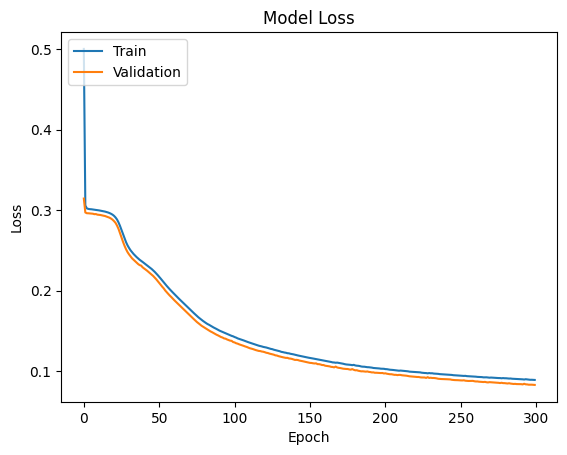

In [32]:
#show loss convergence
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
loss = model.evaluate(test_x, test_y, batch_size=5)
print("test loss:", loss)

182/182 [==============================] - 0s 749us/step - loss: 0.4785 - accuracy: 0.5626
test loss: [0.4784654974937439, 0.5626373887062073]


### Example Predictions
I included the model's predictions versus the real genres for the first 10 movies. As you can see, the model is not incredibly accurate. I also displayed the predictions and accurate genres for 10 randomly chosen movies along with their cast's range scores so you can see how it can potentially impact the model's predictions. I chose 0.5 as the threshold for considering a movie to be a given genre as that indicates that the model predicted that it was more likely than not that that movie was of that genre. To further determine how actors' range may influence the model's accuracy, I experimented with omitting actors with a range score >10, >30, >7, and <10. I found these changes had little impact on the accuracy of the model. It does not appear that the range of cast members, the way I defined it, strongly influences the model's ability to predict the genre of a movie accurately.

In [34]:
def get_prediction(title, movies_df, model):
    genre = df.loc[df['Title']==title]['Genre'].to_string(index=False)
    i = df.index[df['Title']==title][0]
    temp = np.expand_dims(test_x[i], axis=0)
    
    prediction = (model.predict(temp) > 0.5).astype('int')
    preds = []
    indices = np.where(prediction[0] == 1)[0]
    for index in indices:
        preds.append(genres[index])

    print('Title:', title)
    print('Genre:', genre)
    print('Predicted Genre:', preds)

In [35]:
def get_prediction_with_range(title, movies_df, model):
    genre = df.loc[df['Title']==title]['Genre'].to_string(index=False)
    i = df.index[df['Title']==title][0]
    temp = np.expand_dims(test_x[i], axis=0)
    
    prediction = (model.predict(temp) > 0.5).astype('int')
    preds = []
    indices = np.where(prediction[0] == 1)[0]
    for index in indices:
        preds.append(genres[index])

    print('Title:', title)
    print('Genre:', genre)
    print('Predicted Genre:', preds)
    print('Range of Cast:')
    ranges = []
    total = 0
    for actor in df.loc[df['Title']==title]['Cast']:
        for a in actor:
            print("\t", a,":", actor_range[a])
            total = total + actor_range[a]
    print("\t---------------------------------------\n\t TOTAL :", total)

In [36]:
for i in range(10):
    get_prediction(df.iloc[i]['Title'], df, model)
    print()

1/1 [==============================] - 0s 64ms/step
Title: The Shawshank Redemption
Genre: [Drama]
Predicted Genre: ['Drama']

1/1 [==============================] - 0s 16ms/step
Title: The Godfather
Genre: [Crime, Drama]
Predicted Genre: ['Drama', 'Comedy']

1/1 [==============================] - 0s 19ms/step
Title: The Dark Knight
Genre: [Action, Crime, Drama]
Predicted Genre: ['Drama', 'Comedy']

1/1 [==============================] - 0s 17ms/step
Title: The Godfather: Part II
Genre: [Crime, Drama]
Predicted Genre: ['Adventure', 'Fantasy', 'Animation', 'Family']

1/1 [==============================] - 0s 17ms/step
Title: 12 Angry Men
Genre: [Crime, Drama]
Predicted Genre: ['Drama', 'Biography', 'Comedy']

1/1 [==============================] - 0s 17ms/step
Title: The Lord of the Rings: The Return of the King
Genre: [Action, Adventure, Drama]
Predicted Genre: ['Drama', 'Comedy']

1/1 [==============================] - 0s 18ms/step
Title: Pulp Fiction
Genre: [Crime, Drama]
Predicted G

In [37]:
for i in range(10):
    val = random.randint(0,909)
    get_prediction_with_range(df.iloc[val]['Title'], df, model)
    print()

1/1 [==============================] - 0s 18ms/step
Title: The Odd Couple
Genre: [Comedy]
Predicted Genre: ['Drama', 'Crime']
Range of Cast:
	 Jack Lemmon : 24.34920634920635
	 Walter Matthau : 23.94285714285714
	 John Fiedler : 3.6714285714285713
	 Herb Edelman : 0.3666666666666667
	---------------------------------------
	 TOTAL : 52.33015873015873

1/1 [==============================] - 0s 19ms/step
Title: Kaze tachinu
Genre: [Animation, Biography, Drama]
Predicted Genre: ['Adventure', 'Fantasy', 'Animation', 'Family', 'Mystery']
Range of Cast:
	 Hideaki Anno : 3.3428571428571425
	 Hidetoshi Nishijima : 3.3428571428571425
	 Miori Takimoto : 3.3428571428571425
	 Masahiko Nishimura : 3.3428571428571425
	---------------------------------------
	 TOTAL : 13.37142857142857

1/1 [==============================] - 0s 19ms/step
Title: Ôkami kodomo no Ame to Yuki
Genre: [Animation, Drama, Fantasy]
Predicted Genre: ['Drama', 'Biography']
Range of Cast:
	 Aoi Miyazaki : 3.471428571428571
	 Tak

### Size of the Cast
To determine whether the number of cast members taken into consideration can influence the model's predictive ability, I experimented with including 1, 2, and 3 cast members as opposed to four. The change in cast size did not strongly impact the ability of the model to predict a movie's genre, with a cast size of two, half the original size, the accuracy only increased or decreased by about 10% on different runs. However, this lack of change could partly be due to the small cast size. In the future, I could find a data set that includes longer lists of cast members to better determine how cast size impacts the model's accuracy.

In [38]:
for index, movie in df_stripped.iterrows():
    i = 0
    for j in range (len(movie['Cast'])):
        if i >= 2 and movie['Cast'][j] == 1:
            movie['Cast'][j] = 0  
        if movie['Cast'][j] == 1:
            i = i + 1
            
df_stripped.head()

,Cast,Drama,Crime,Action,Adventure,Biography,History,Sci-Fi,Romance,Western,...,Thriller,Animation,Family,War,Mystery,Music,Horror,Musical,Film-Noir,Sport
0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
train2,left2 = train_test_split(df_stripped, test_size=0.2, random_state=67)
valid2,test2 = train_test_split(df_stripped, test_size=0.5, random_state=67)
print(train2.shape)
print(valid2.shape)
print(test2.shape)

(1456, 22)
(910, 22)
(910, 22)


In [40]:
train_x2 = np.array(train2.Cast.to_list())

valid_x2 = np.array(valid2.Cast.to_list())

test_x2 = np.array(test2.Cast.to_list())

train_y2 = train.iloc[: , 1:].to_numpy()
valid_y2 = valid.iloc[: , 1:].to_numpy()
test_y2 = test.iloc[: , 1:].to_numpy()

print(train_x2.shape)
print(train_y2.shape)

(1456, 4512)
(1456, 21)


In [41]:
model2 = keras.Sequential([
    keras.layers.Dense(3, activation=tf.nn.relu, input_shape=(train_x2.shape[1],)),
    keras.layers.Dense(6, activation=tf.nn.relu),
    keras.layers.Dense(11, activation=tf.nn.relu),
    keras.layers.Dense(21, activation=tf.nn.sigmoid)
])
model2.compile(
    optimizer=keras.optimizers.Adagrad(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print (model2.summary())
print(train_x2.shape[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 13539     
                                                                 
 dense_5 (Dense)             (None, 6)                 24        
                                                                 
 dense_6 (Dense)             (None, 11)                77        
                                                                 
 dense_7 (Dense)             (None, 21)                252       
                                                                 
Total params: 13,892
Trainable params: 13,892
Non-trainable params: 0
_________________________________________________________________
None
4512


In [42]:
hist2 = model2.fit(train_x2, train_y2, batch_size=5, epochs=epochs, validation_data = (valid_x2, valid_y2))

Epoch 1/300
292/292 [==============================] - 1s 2ms/step - loss: 0.4940 - accuracy: 0.5989 - val_loss: 0.3132 - val_accuracy: 0.6264
Epoch 2/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3058 - accuracy: 0.6161 - val_loss: 0.2971 - val_accuracy: 0.6264
Epoch 3/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3019 - accuracy: 0.6161 - val_loss: 0.2970 - val_accuracy: 0.6264
Epoch 4/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3017 - accuracy: 0.6161 - val_loss: 0.2965 - val_accuracy: 0.6264
Epoch 5/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3015 - accuracy: 0.6161 - val_loss: 0.2961 - val_accuracy: 0.6264
Epoch 6/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3013 - accuracy: 0.6161 - val_loss: 0.2961 - val_accuracy: 0.6264
Epoch 7/300
292/292 [==============================] - 0s 1ms/step - loss: 0.3013 - accuracy: 0.6161 - val_loss: 0.2959 - val_accuracy: 0.6264

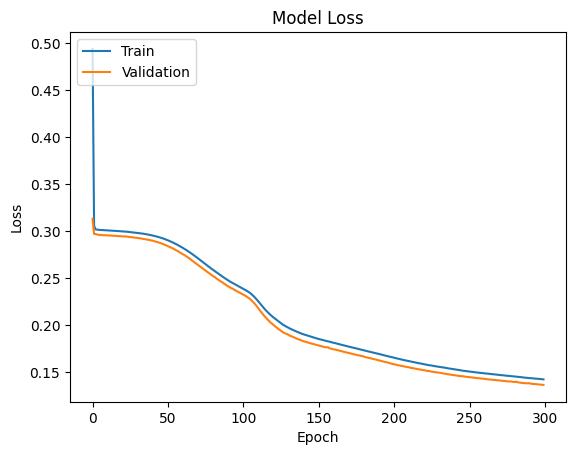

In [43]:
#show loss convergence
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
loss2 = model2.evaluate(test_x2, test_y2, batch_size=50)
print("test loss:", loss2)

19/19 [==============================] - 0s 1ms/step - loss: 0.3410 - accuracy: 0.6275
test loss: [0.34096479415893555, 0.6274725198745728]


### Conclusion
The cast of a movie is likely not a great predictor of a movie's genre, regardless of the range the movie's actor possess. However, there were also various limitations with this model. Firstly, many actors in the data sets were only present in one movie, making it difficult to assess their range due to the limited data on their appearances. As a result, their range score will be biased toward the lower end. A wider representation of these actor's acting careers would be needed in order to improve the accuracy of their range score. Furthermore, the quality of the actor's performance was not quantified in the data set, so it cannot be taken into account when calculating their range. While I attempted to replicate an assessment of their acting quality using movie ratings, it is not a perfect substitute. There is also no documentation of the character an actor played in a movie. While two movies can have very dissimilar genres, the role played by an actor in those movies may be similar. For example, Alan Rickman plays characters with somewhat similar demeanors in Harry Potter and Die Hard, yet these two movies have very different genres. Resultantly, actors' range scores even less accurately reflect their true range. The model itself was limited by the small number of cast members provided by the data sets. The data sets only included four of the main actors in a movie for most movies. While this may improve the model by filtering out small acting roles that could negatively impact its predictive ability, I was unable to verify that as I could not train or test the model on a larger cast size. Slightly increasing the cast size, to somewhere between 5 and 7 actors, could potentially improve the accuracy of the model. However, further work would need to be done to perfect the estimation of an actor's range and to determine how cast size impacts the model's accuracy.